
# ARSENL Backscatter Experiments

Grant Kirchhoff
06-23-2022
University of Colorado Boulder

Fit the photon arrival rate to exponentiated polynomial profiles from ARSENL INPHAMIS lidar. 

IMPORTANT: Set data path settings in
'load_ARSENL_data.py' first.

In [1]:
import numpy as np
import pandas as pd
import time
import pickle
import matplotlib.pyplot as plt
import torch
from scipy import stats
import os
import xarray as xr

In [187]:
### CONSTANTS ####
c = 299792458                      # [m/s] Speed of light
tstamp_int = 25                    # Timestamp interval (e.g., timestamp recorded in intervals of 25)
max_rollover = 2**25 * tstamp_int  # [ps] the maximum timestamp before instrument timer rolls over

### PARAMETERS ###
exclude_bnd = [0, 60000]           # Set boundaries for binning to exclude outliers
exclude = True                     # Set TRUE to exclude data to work with smaller dataset
excl_val = 10000                  # Include up to certain value

cwd = os.getcwd()
data_dir = cwd + r'/../Data/Deadtime_Experiments_HiFi'
fname = r'/Dev_0_-_2022-04-15_10.49.58.ARSENL.OD00.ARSENL.nc'

In [188]:
ds = xr.open_dataset(data_dir+fname)                                   # xarray Dataset

flight_time = ds.time_tag * tstamp_int
distance = flight_time / 1e12 * c / 2

flight_time = flight_time[np.where((flight_time >= exclude_bnd[0]) \
                                   & (flight_time < exclude_bnd[1]))]  # Exclude specified t.o.f. bins

cnt_phot_fit = len(ds.sync_index)

if exclude:
    flight_time = flight_time[:excl_val]
    cnt_phot_fit = ds.sync_index[ds.time_tag_sync_index[excl_val].item()].item()

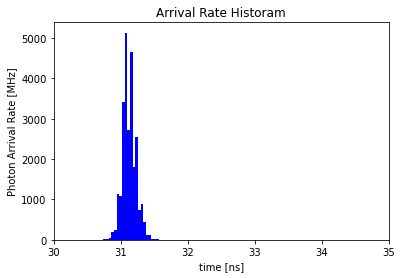

In [189]:
# Scaled time-of-flight histogram
fig = plt.figure()
ax = fig.add_subplot(111)
n, bins = np.histogram(flight_time/1000, bins=1000)
binwidth = np.diff(bins)[0]
N = n / binwidth / 1e-9 / cnt_phot_fit  # [Hz] Scaling counts to arrival rate
center = 0.5 * (bins[:-1] + bins[1:])
ax.bar(center, N/1e6, align='center', width=binwidth, color='b')
ax.set_xlim([30,35])
ax.set_title('Arrival Rate Historam')
ax.set_xlabel('time [ns]')
ax.set_ylabel('Photon Arrival Rate [MHz]')
plt.show()

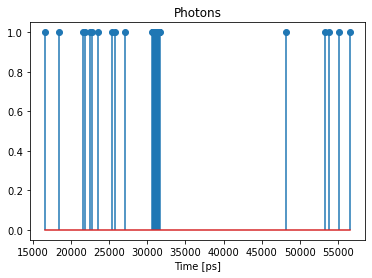

In [190]:
plt.figure()
plt.stem(flight_time, np.ones(flight_time.size))
plt.title('Photons')
plt.xlabel('Time [ps]')
plt.show()

### Now applying the curve_fit routine to my data. Code pulled from Matt Hayman's "Fit_TimeTag_Gaussian.ipynb" and adapted to fit to arbitrary exponentiated polynomials.

In [191]:
# Chebyshev polynomial matrix generator
def cheby_poly(x, M):
    """
    Parameters:
    x (array-like): Values to be evaluated on in chebyshev polynomial      \\ [Nx1]
    M (int)        : *Highest* order term of polynomial (e.g., x^2 --> M = 2) \\ []
    Returns:
    chebyshev polynomial matrix (array-like): Evaluated polynomial \\ [NxM]
    """
    
    def cheby(x, m):
        """
        Helper to calculate value of specific chebyshev order
        """
        T0 = x**0
        T1 = x**1
        if m == 0:   return T0
        elif m == 1: return T1
        else:        return 2*x*cheby(x, m-1) - cheby(x, m-2)
    
    N = len(x)
    model_out = np.zeros((N, M+1))
    for i in range(M+1):
        model_out[:, i] = cheby(x, i)
    
    return torch.tensor(model_out)

In [192]:
# build the fit model as a NN module
class Fit_Pulse(torch.nn.Module):
    def __init__(self, t_max):
        """
        Instantiate and initialize the fit parameters.
        """
        super().__init__()

        self.log_C2 = torch.nn.Parameter(-1*torch.ones(()))    # Quadratic term amplitude
        self.log_C1 = torch.nn.Parameter(1*torch.ones(()))    # Linear term amplitude
        self.log_C0 = torch.nn.Parameter(-1*torch.ones(()))    # DC term        
        self.log_A  = torch.nn.Parameter(1*torch.ones(()))    # Overall amplitude
        self.log_b  = torch.nn.Parameter(1*torch.ones(()))    # Overall offset
        self.t_max = t_max                                    # Time elapsed per shot
        
        self.sqrt_2pi = torch.sqrt(torch.tensor(2*np.pi))
        self.sqrt_2  = torch.sqrt(torch.tensor(2.0))
        
    @staticmethod
    # Helper for numerical integration (trapezoidal method)
    def trapezoid(vals, dx):
        trap_intgrl = 0
        for i in range(len(vals)-1):
            trap_intgrl += vals[i] + vals[i+1]
        trap_intgrl *= dx/2
        return trap_intgrl

    def forward(self, t, intgrl_N):
        """
        Forward model the profile for input time t of polynomial order M (e.g., x^2 --> M=2).
        Also return the integral.
        t (array-like): time stamps                              \\ [Nx1]
        intgrl_N (int): number of steps in numerical integration \\ []
        """
        C2 = torch.exp(self.log_C2)
        C1 = torch.exp(self.log_C1)
        C0 = torch.exp(self.log_C0)
        b  = torch.exp(self.log_b)
        
        # orthonormalize by leveraging chebyshev polynomials, then calculate forward model
        t_norm = t / self.t_max                       # Normalize timestamps
        C = torch.tensor([C0, C1, C2], dtype=float)
        M = len(C) - 1
        t_poly_cheb = cheby_poly(t_norm, M)           # Generate chebyshev timestamp basis
        poly = t_poly_cheb @ C
        model_out = torch.exp(poly) + b             # Forward model
        
        # calculate the integral
        intgrl_N = 100
        t_pts, dx = np.linspace(0, self.t_max, intgrl_N, retstep=True)
        t_pts /= self.t_max                                      # Normalize
        t_poly_cheb = cheby_poly(t_pts, M)                        # Generate chebyshev time basis
        poly = t_poly_cheb @ C
        eval_model = torch.exp(poly) + b
        integral_out = self.trapezoid(eval_model, dx)            # Numerically integrate (trapezoidal)
            
        return model_out, integral_out

In [193]:
def pois_loss(prof,integral):
    """
    Poisson point process loss function
    prof: estimated photon arrival rate evaluated at
        each time tag
    integral: integral of prof at t_max
    """
    return integral-torch.sum(torch.log(prof))

In [194]:
# optimization parameters

rel_step_lim = 1e-15  # termination criteria based on step size
max_epochs = 5000     # maximum number of iterations/epochs
learning_rate = 1e-2  # ADAM learning rate
term_persist = 20     # relative step size averaging interval in iterations

In data set, the frequency of the sync pulses is ~14.2kHz. Therefore, t_max ~= 70.2043 usec. Might need to look into having this dynamically adjusted.

In [195]:
# I define the maximum time as a fixed value. This is the mode of the recorded elapsed time between shots.
# Time vector per shot (sync event)
t_min = 0
avg_sync_diff = ds.sync_delta.mean() * tstamp_int / 1e12  # [s]
t_max = avg_sync_diff.item()
dt = tstamp_int * 1e-12                                    # [s]
t_fine = np.arange(t_min, t_max, dt)

In [196]:
# initialize for fit loop
fit_model = Fit_Pulse(t_max)
optimizer = torch.optim.Adam(fit_model.parameters(), lr=learning_rate)
epoch = 0
rel_step = 1e3*rel_step_lim
train_loss_lst = []
rel_step_lst = []

init_log_C0 = fit_model.log_C0.item()
init_log_C1 = fit_model.log_C1.item()
init_log_C2 = fit_model.log_C2.item()
init_log_b = fit_model.log_b.item()

In [197]:
# set the loss function to use a 
# Poisson point process likelihood function
loss_fn = pois_loss

In [198]:
intgrl_N = 1000                   # Set number of steps in numerical integration
t_phot_fit = flight_time * 1e-12  # [s] convert to seconds
t_phot_fit_tnsr = torch.tensor(t_phot_fit.to_numpy())

In [199]:
# perform fit
while rel_step > rel_step_lim and epoch < max_epochs:
    
    fit_model.train()
    pred, integral = fit_model(t_phot_fit_tnsr, intgrl_N)
    loss = loss_fn(pred, integral*cnt_phot_fit)  # add regularization here
    train_loss_lst += [loss.item()]

    # calculate relative step as an average over the last
    # term_persist iterations
    if epoch == 0:
        rel_step_lst+=[1e3*rel_step_lim]
        rel_step = 1e3*rel_step_lim
    else:
        rel_step_lst+=[(train_loss_lst[-2]-train_loss_lst[-1])/np.abs(train_loss_lst[-2])]
        rel_step = np.abs(np.array(rel_step_lst)[-term_persist:].mean())

    # update estimated parameters
    loss.backward()
    optimizer.step()
    
    # zero out the gradient for the next step
    optimizer.zero_grad()
    
    epoch+=1
    

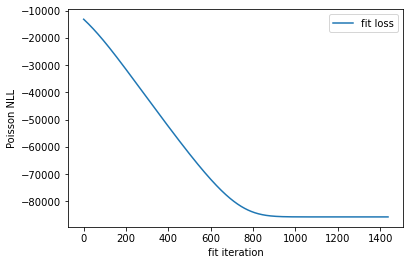

In [200]:
# plot the loss over iterations
plt.figure()
plt.plot(train_loss_lst,label='fit loss')
plt.xlabel('fit iteration')
plt.ylabel('Poisson NLL')
plt.legend()

In [201]:
pred_mod_full, integral_full = fit_model(torch.tensor(t_fine), intgrl_N)

In [202]:
print('Initial C0: {}'.format(np.exp(init_log_C0)))
print('Initial C1: {}'.format(np.exp(init_log_C1)))
print('Initial C2: {}'.format(np.exp(init_log_C2)))
print('Initial b: {}\n'.format(np.exp(init_log_b)))

print('Final C0: {}'.format(torch.exp(fit_model.log_C0)))
print('Final C1: {}'.format(torch.exp(fit_model.log_C1)))
print('Final C2: {}'.format(torch.exp(fit_model.log_C2)))
print('Final b: {}'.format(torch.exp(fit_model.log_b)))

Initial C0: 0.36787944117144233
Initial C1: 2.718281828459045
Initial C2: 0.36787944117144233
Initial b: 2.718281828459045

Final C0: 0.3678794503211975
Final C1: 2.7182817459106445
Final C2: 0.3678794503211975
Final b: 14372.712890625


In [203]:
print("Sample average arrival time: {:.4f} ns".format(torch.mean(t_phot_fit_tnsr)*1e9))

Sample average arrival time: 31.1331 ns


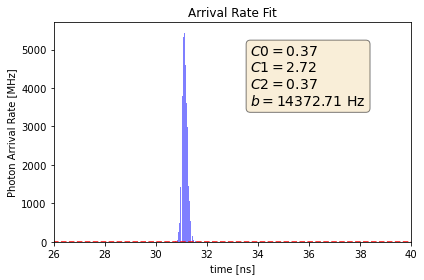

In [205]:
fig = plt.figure()
ax = fig.add_subplot(111)

# Scaled histogram
n, bins = np.histogram(flight_time/1000, bins=2000)
binwidth = np.diff(bins)[0]
N = n / binwidth / 1e-9 / cnt_phot_fit  # [Hz] Scaling counts to arrival rate
center = 0.5 * (bins[:-1] + bins[1:])
ax.bar(center, N/1e6, align='center', width=binwidth, color='b', alpha=0.5)

# Arrival rate fit
fit_rate = pred_mod_full.detach().numpy()  # [Hz] Fitted arrival rate
ax.plot(t_fine*1e9, fit_rate/1e6,'r--')
ax.set_xlim([26, 40])
ax.set_title('Arrival Rate Fit')
ax.set_xlabel('time [ns]')
ax.set_ylabel('Photon Arrival Rate [MHz]')
textstr = '\n'.join((
    r'$C0=%.2f$' % (torch.exp(fit_model.log_C0)),
    r'$C1=%.2f$' % (torch.exp(fit_model.log_C1)),
    r'$C2=%.2f$' % (torch.exp(fit_model.log_C2)),
    r'$b=%.2f$ Hz' % (torch.exp(fit_model.log_b))))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.55, 0.90, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
plt.tight_layout()
plt.show()



### Graveyard ###

In [93]:
class NumericalIntegrator:
    def riemann(f, eval_pts, dx):
        integral = 0
        for i in range(len(eval_pts)):
            integral += f(eval_pts[i])
        integral *= dx
        return integral

    def trapezoidal(f, eval_pts, dx):
        integral = 0
        for i in range(len(eval_pts)-1):
            integral += f(eval_pts[i]) + f(eval_pts[i+1])
        integral *= dx / 2
        return integral

    def simpsons(f, eval_pts, dx):
        integral = 0
        for i in range(len(eval_pts)-2):
            integral += f(eval_pts[i]) + 4*f(eval_pts[i+1]) + f(eval_pts[i+2])
        integral *= dx / 2 / 3
        return integral
